In [38]:
# 인공신경망관련 패키지
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

# 회귀분석 관련 패키지
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from xgboost import XGBRegressor


# 시각화 패키지
from matplotlib import pyplot as plt
import seaborn as sb

# 데이터 처리를 위한 패키지
import pandas as pd
import numpy as np
import math

# 다중공선성(multicollinearity) 처리를 위한VIF 확인 패키지
from statsmodels.stats.outliers_influence import variance_inflation_factor

# DeprecationWarning경고 무시
# 향후 안쓰일 함수들을 이용해서 만들어져 있기 때문에 필요하다 없으면, 사방이 붉어진다.
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [39]:
#########################################################################
# MAD 기반 예제코드
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh 

# 출처: https://pythonanalysis.tistory.com/7 [Python 데이터 분석]
#########################################################################

# 소셜 데이터 처리를 위한 함수
# 1. 모든 소셜 데이터 column들의 첫번째는 : 날짜다.
# 2. 각 소셜데이터는 social_키워드.블로그/트위터/뉴스/총합 으로 되어 있다.
def changeColNames(d,before, after) : 
    # 컬럼이름 시리즈로 만들어 반환
    # 통합하기 쉽게, 모든 데이터들의 날짜컬럼 이름을 date로 통일
    new_col_names = ['date']
    new_col_names.extend(list(d.columns)[1:])
    d.columns = new_col_names
    return pd.Series(d.columns).apply(lambda x : x.replace(before,after))

#########################################################################
# modeling 함수로 만들어 처리하기
def linReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item, cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    model = LinearRegression().fit(X_train, y_train)
  
    print('LinearRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(model.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(model.score(X_test, y_test)))

    
def ridgeReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(X_train, y_train)
    
    print('RidgeRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(ridge.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(ridge.score(X_test, y_test)))


def lassoReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    lasso = Lasso(alpha=0.1, max_iter=1000).fit(X=X_train, y=y_train)
  
    print('LassoRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(lasso.score(X_train, y_train)) )
    print('검증세트점수 : {:.2f}'.format(lasso.score(X_test, y_test)) )

    #사용한 특성수
    print('사용한 특성수 : {}'.format(np.sum(lasso.coef_ != 0)) )
#########################################################################

# 자료가 1일 1행이라는 전제하에
# df길이를 이용하여 날짜수를 계산, 이후 2016년 1월1일을 1번째주 1일이라 기준하에
# 몇번째 주인지 알려주는 컬럼 추가. 향후 주단위로 종합할때 스인다.
def addDayWeek(df):
    df_work = df.copy()
    df_work['day'] = pd.Series(range(1,df_work.shape[0]+1))
    df_work['week'] = df_work['day'].apply(lambda x : math.ceil(x/7))
    return df_work
#########################################################################
# 자료를 병합해주는 함수, 어떤 item인지 어느 컬럼을 기준으로 할지 받아서 병합
def mergeForAnalysis(df1, df2, df3, item, on_what='date'):
    merged_df = pd.merge(df1.loc[df1.category==item], df2, on=on_what, how='left')
    merged_df = pd.merge(merged_df, df3, on=on_what, how='left')
    return merged_df


#########################################################################
def lowVIF(df, n=7, cols_using =['temp', 'cloud', 'wind','humid', 'hpa', 'sun_time', 'lgt_time', 
       'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25'] ):
    col_to_use = cols_using
    vif = pd.DataFrame()
    vif["VIF_Factor"] = [variance_inflation_factor(
        df[col_to_use].values, i) for i in range(df[col_to_use].shape[1])]
    vif["features"] = col_to_use
    vif.sort_values("VIF_Factor")
    lowest_vif = vif.sort_values("VIF_Factor")[:n].reset_index()
    lowest_vif.drop(columns='index', inplace=True)
    return lowest_vif

#########################################################################
# ols모델용 formula 생성
def formulaGen(target, ind_features):
    '''
    formulaGen(목표컬럼명,[변수컬럼명1, 변수컬럼명2,...])
    '''
    custom_formula = target + " ~ "
    for f in range(len(ind_features)):
        custom_formula += ind_features[f]
        if f!=(len(ind_features)-1):
            custom_formula += " + "
    return custom_formula


#########################################################################

In [40]:
# 데이터 불러오기 (전처리 된 GS, 랄라블라, 날씨)
gs = pd.read_csv('d:/project/contest/data/processed/p_gs.csv', parse_dates=['date'])
lv = pd.read_csv('d:/project/contest/data/processed/p_lavla.csv', parse_dates=['date'])
w = pd.read_csv('d:/project/contest/data/processed/p_wUVair_seoul.csv', parse_dates=['date'], index_col=0)
sns_all = pd.read_csv('d:/project/contest/data/processed/social_all.csv', parse_dates=['date'])

# GS/lv 서울시만
gs_seoul = gs.loc[gs.pvn_nm =='서울특별시']
lv_seoul = lv.loc[lv.pvn_nm =='서울특별시']
w_seoul = w.loc[w['loc']==108]

cols_to_keep = ['date','bor_nm','gender','age_cd','category','qty']

# 일일, 구단위, 상품별 판매량 종합
gs_grouped = gs_seoul[cols_to_keep].groupby(by=['date','bor_nm','category']).sum().reset_index()

# 일단위로 자료 종합(qty는 일일 합계)
day_gs_grouped = gs_grouped.groupby(by=['date','category']).sum().reset_index()

In [41]:
# 아이스크림만 빼서 df생성
item = '아이스크림'
grouped_by = 'date'
day_gs_grouped_w_item = pd.merge(day_gs_grouped.loc[day_gs_grouped.category==item],w_seoul,on='date',how='left')
# day_gs_grouped_w_item.head(3)
day_gs_grouped_w_sns_item = pd.merge(day_gs_grouped_w_item, sns_all,on='date',how='left')

# 일단 uv = 자외선 지수는 결측치가 많아서 제외
selected_cols = ['date', 'category', 'qty', 'temp', 'rain', 'cloud', 'wind','humid', 'hpa',
                 'sun_time', 'lgt_time', 'snow',
                 'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25',
                 'pm_blog', 'pm_twitter', 'pm_news', 'pm_total',
                 'health_blog', 'health_twitter', 'health_news', 'health_total',
                 'date_blog', 'date_twitter', 'date_news', 'date_total',
                 'br_blog', 'br_twitter', 'br_news', 'br_total',
                 'hobby_blog', 'hobby_twitter', 'hobby_news', 'hobby_total']
gs_day_w = day_gs_grouped_w_sns_item[selected_cols]

## 모든 변수 - 날씨 소셜 전부

In [6]:
# train_data = gs_day_w.loc[gs_day_w.date.between('2016-01-01','2017-12-31')]
# test_data = gs_day_w.loc[gs_day_w.date.between('2018-01-01','2018-12-31')]

# # train_data.describe() # 731일
# # test_data.describe() # 365일

# # 3년치 데이터 분리 : 종속변수('qty': 판매량)와 독립변수(판매량 제외 나머지 전부)
# combined = gs_day_w.loc[:,'temp':]
# target = gs_day_w.loc[:,'qty']

##### 2016~2017년도는 예측 잘함, 2018년도 폭망 => 과적합 발생

# 날씨만 가지고 시도

In [42]:
list_col = ['temp', 'rain', 'cloud', 'wind', 'humid','hpa', 'sun_time', 'lgt_time', 'snow',
              'SO2', 'CO', 'O3', 'NO2', 'PM10','PM25',]
gs_day_w = gs_day_w[['date','qty']+list_col].groupby('date').mean().reset_index()
# gs_week_w.tail(2)

train_data = gs_day_w.loc[gs_day_w.date.between('2016-01-01','2017-12-31')]
test_data = gs_day_w.loc[gs_day_w.date.between('2018-01-01','2018-12-31')]

# 3년치 데이터 분리 : 종속변수('qty': 판매량)와 독립변수(판매량 제외 나머지 전부)
combined = gs_day_w.loc[:,'temp':'PM25']
target = gs_day_w.loc[:,'qty']

In [43]:
def get_cols_with_no_nans(df,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type : 
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans    
    '''
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

In [44]:
num_cols = get_cols_with_no_nans(combined , 'num')
cat_cols = get_cols_with_no_nans(combined , 'no_num')

print ('Number of numerical columns with no nan values :',len(num_cols))
print ('Number of nun-numerical columns with no nan values :',len(cat_cols))

Number of numerical columns with no nan values : 15
Number of nun-numerical columns with no nan values : 0


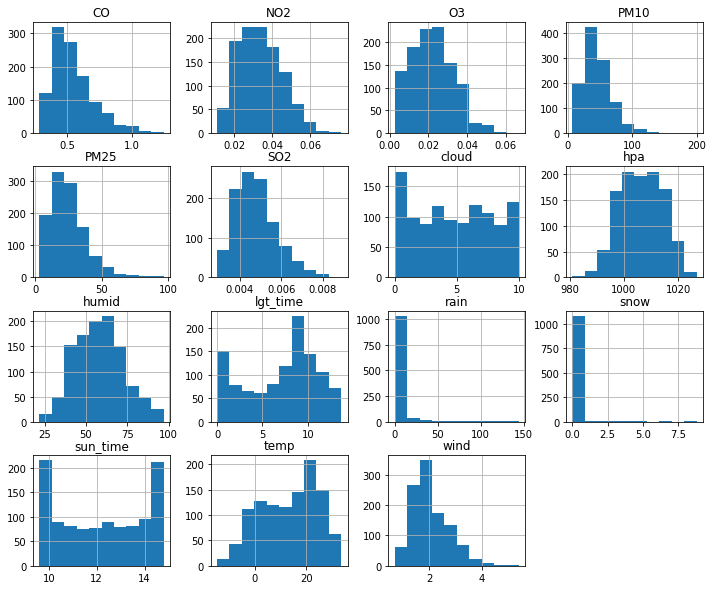

In [45]:
combined = combined[num_cols + cat_cols]
combined.hist(figsize = (12,10))
plt.show()

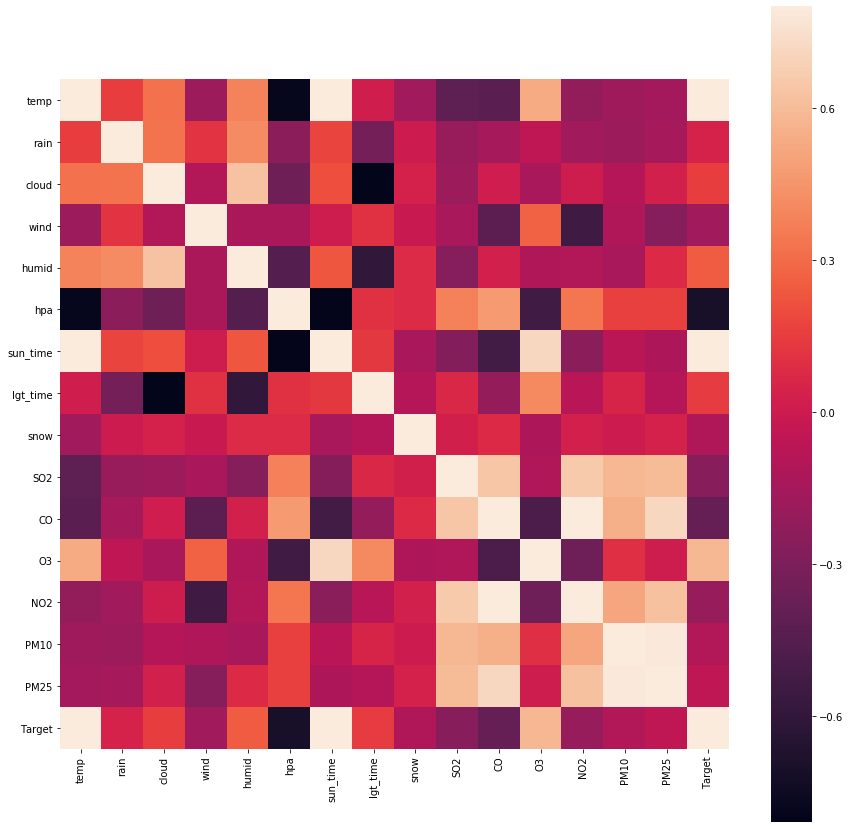

In [46]:
train_data = train_data[num_cols + cat_cols]
train_data['Target'] = target

C_mat = train_data.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

In [47]:
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df
    

print('There were {} columns before encoding categorical features'.format(combined.shape[1]))
combined = oneHotEncode(combined, cat_cols)
print('There are {} columns after encoding categorical features'.format(combined.shape[1]))

There were 15 columns before encoding categorical features
There are 15 columns after encoding categorical features


In [48]:
cut_line = 732
def split_combined():
    global combined
    train = combined[:cut_line]
    test = combined[cut_line:]

    return train , test 
  
train, test = split_combined()

train.shape

(732, 15)

In [49]:
# 신경망 모델 생성
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               2048      
_________________________________________________________________
dense_7 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_9 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 166,913
Trainable params: 166,913
Non-trainable params: 0
_________________________________________________________________


In [50]:
checkpoint_name = 'GS-'+item+grouped_by+'-Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [51]:
NN_model.fit(train, target[:cut_line], epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Train on 585 samples, validate on 147 samples
Epoch 1/500
585/585 [==============================] - 0s 542us/step - loss: 21308.6679 - mean_absolute_error: 21308.6679 - val_loss: 12582.1182 - val_mean_absolute_error: 12582.1182

Epoch 00001: val_loss improved from inf to 12582.11825, saving model to GS-아이스크림date-Weights-001--12582.11825.hdf5
Epoch 2/500
585/585 [==============================] - 0s 80us/step - loss: 14063.3431 - mean_absolute_error: 14063.3431 - val_loss: 13471.8344 - val_mean_absolute_error: 13471.8344

Epoch 00002: val_loss did not improve from 12582.11825
Epoch 3/500
585/585 [==============================] - 0s 77us/step - loss: 11236.7449 - mean_absolute_error: 11236.7449 - val_loss: 6650.4499 - val_mean_absolute_error: 6650.4499

Epoch 00003: val_loss improved from 12582.11825 to 6650.44991, saving model to GS-아이스크림date-Weights-003--6650.44991.hdf5
Epoch 4/500
585/585 [==============================] - 0s 75us/step - loss: 11199.6958 - mean_absolute_error: 11199

585/585 [==============================] - 0s 72us/step - loss: 3546.5119 - mean_absolute_error: 3546.5119 - val_loss: 4235.9087 - val_mean_absolute_error: 4235.9087

Epoch 00068: val_loss did not improve from 2774.08859
Epoch 69/500
585/585 [==============================] - 0s 80us/step - loss: 3304.5334 - mean_absolute_error: 3304.5334 - val_loss: 3849.5370 - val_mean_absolute_error: 3849.5370

Epoch 00069: val_loss did not improve from 2774.08859
Epoch 70/500
585/585 [==============================] - 0s 78us/step - loss: 3388.0698 - mean_absolute_error: 3388.0698 - val_loss: 4025.7522 - val_mean_absolute_error: 4025.7522

Epoch 00070: val_loss did not improve from 2774.08859
Epoch 71/500
585/585 [==============================] - 0s 78us/step - loss: 3468.1752 - mean_absolute_error: 3468.1752 - val_loss: 4881.0637 - val_mean_absolute_error: 4881.0637

Epoch 00071: val_loss did not improve from 2774.08859
Epoch 72/500
585/585 [==============================] - 0s 78us/step - loss: 

585/585 [==============================] - 0s 82us/step - loss: 3318.6994 - mean_absolute_error: 3318.6994 - val_loss: 3643.9554 - val_mean_absolute_error: 3643.9554

Epoch 00103: val_loss did not improve from 2774.08859
Epoch 104/500
585/585 [==============================] - 0s 78us/step - loss: 3381.2343 - mean_absolute_error: 3381.2343 - val_loss: 4300.7215 - val_mean_absolute_error: 4300.7215

Epoch 00104: val_loss did not improve from 2774.08859
Epoch 105/500
585/585 [==============================] - 0s 77us/step - loss: 3358.3977 - mean_absolute_error: 3358.3977 - val_loss: 4092.9145 - val_mean_absolute_error: 4092.9145

Epoch 00105: val_loss did not improve from 2774.08859
Epoch 106/500
585/585 [==============================] - 0s 77us/step - loss: 3329.8840 - mean_absolute_error: 3329.8840 - val_loss: 4543.1384 - val_mean_absolute_error: 4543.1384

Epoch 00106: val_loss did not improve from 2774.08859
Epoch 107/500
585/585 [==============================] - 0s 77us/step - lo

585/585 [==============================] - 0s 82us/step - loss: 3246.9291 - mean_absolute_error: 3246.9291 - val_loss: 4742.9044 - val_mean_absolute_error: 4742.9044

Epoch 00138: val_loss did not improve from 2774.08859
Epoch 139/500
585/585 [==============================] - 0s 80us/step - loss: 3275.9592 - mean_absolute_error: 3275.9592 - val_loss: 3503.3992 - val_mean_absolute_error: 3503.3992

Epoch 00139: val_loss did not improve from 2774.08859
Epoch 140/500
585/585 [==============================] - 0s 77us/step - loss: 3547.3464 - mean_absolute_error: 3547.3464 - val_loss: 4361.5440 - val_mean_absolute_error: 4361.5440

Epoch 00140: val_loss did not improve from 2774.08859
Epoch 141/500
585/585 [==============================] - 0s 78us/step - loss: 3308.4764 - mean_absolute_error: 3308.4764 - val_loss: 3965.9823 - val_mean_absolute_error: 3965.9823

Epoch 00141: val_loss did not improve from 2774.08859
Epoch 142/500
585/585 [==============================] - 0s 80us/step - lo

585/585 [==============================] - 0s 87us/step - loss: 3229.8876 - mean_absolute_error: 3229.8876 - val_loss: 4293.9178 - val_mean_absolute_error: 4293.9178

Epoch 00173: val_loss did not improve from 2774.08859
Epoch 174/500
585/585 [==============================] - 0s 85us/step - loss: 3353.6860 - mean_absolute_error: 3353.6860 - val_loss: 5593.3237 - val_mean_absolute_error: 5593.3237

Epoch 00174: val_loss did not improve from 2774.08859
Epoch 175/500
585/585 [==============================] - 0s 87us/step - loss: 3297.7211 - mean_absolute_error: 3297.7211 - val_loss: 5028.8620 - val_mean_absolute_error: 5028.8620

Epoch 00175: val_loss did not improve from 2774.08859
Epoch 176/500
585/585 [==============================] - 0s 77us/step - loss: 3399.4990 - mean_absolute_error: 3399.4990 - val_loss: 3757.7343 - val_mean_absolute_error: 3757.7343

Epoch 00176: val_loss did not improve from 2774.08859
Epoch 177/500
585/585 [==============================] - 0s 80us/step - lo

585/585 [==============================] - 0s 87us/step - loss: 3264.7806 - mean_absolute_error: 3264.7806 - val_loss: 3468.5493 - val_mean_absolute_error: 3468.5493

Epoch 00208: val_loss did not improve from 2774.08859
Epoch 209/500
585/585 [==============================] - 0s 85us/step - loss: 3505.8411 - mean_absolute_error: 3505.8411 - val_loss: 3807.4305 - val_mean_absolute_error: 3807.4305

Epoch 00209: val_loss did not improve from 2774.08859
Epoch 210/500
585/585 [==============================] - 0s 92us/step - loss: 3342.9885 - mean_absolute_error: 3342.9885 - val_loss: 5712.6363 - val_mean_absolute_error: 5712.6363

Epoch 00210: val_loss did not improve from 2774.08859
Epoch 211/500
585/585 [==============================] - 0s 89us/step - loss: 3350.0112 - mean_absolute_error: 3350.0112 - val_loss: 4072.2734 - val_mean_absolute_error: 4072.2734

Epoch 00211: val_loss did not improve from 2774.08859
Epoch 212/500
585/585 [==============================] - 0s 87us/step - lo

585/585 [==============================] - 0s 102us/step - loss: 3263.2609 - mean_absolute_error: 3263.2609 - val_loss: 4944.4682 - val_mean_absolute_error: 4944.4682

Epoch 00243: val_loss did not improve from 2774.08859
Epoch 244/500
585/585 [==============================] - 0s 101us/step - loss: 3249.9720 - mean_absolute_error: 3249.9720 - val_loss: 3794.4012 - val_mean_absolute_error: 3794.4012

Epoch 00244: val_loss did not improve from 2774.08859
Epoch 245/500
585/585 [==============================] - 0s 94us/step - loss: 3259.3721 - mean_absolute_error: 3259.3721 - val_loss: 3933.5982 - val_mean_absolute_error: 3933.5982

Epoch 00245: val_loss did not improve from 2774.08859
Epoch 246/500
585/585 [==============================] - 0s 94us/step - loss: 3257.2366 - mean_absolute_error: 3257.2366 - val_loss: 4058.6585 - val_mean_absolute_error: 4058.6585

Epoch 00246: val_loss did not improve from 2774.08859
Epoch 247/500
585/585 [==============================] - 0s 104us/step -

585/585 [==============================] - 0s 126us/step - loss: 3361.6343 - mean_absolute_error: 3361.6343 - val_loss: 4632.9983 - val_mean_absolute_error: 4632.9983

Epoch 00278: val_loss did not improve from 2774.08859
Epoch 279/500
585/585 [==============================] - 0s 116us/step - loss: 3226.9009 - mean_absolute_error: 3226.9009 - val_loss: 2893.0243 - val_mean_absolute_error: 2893.0243

Epoch 00279: val_loss did not improve from 2774.08859
Epoch 280/500
585/585 [==============================] - 0s 113us/step - loss: 3184.2469 - mean_absolute_error: 3184.2469 - val_loss: 3367.3679 - val_mean_absolute_error: 3367.3679

Epoch 00280: val_loss did not improve from 2774.08859
Epoch 281/500
585/585 [==============================] - 0s 101us/step - loss: 3270.9721 - mean_absolute_error: 3270.9721 - val_loss: 4935.3558 - val_mean_absolute_error: 4935.3558

Epoch 00281: val_loss did not improve from 2774.08859
Epoch 282/500
585/585 [==============================] - 0s 107us/step


Epoch 00312: val_loss did not improve from 2397.12362
Epoch 313/500
585/585 [==============================] - 0s 116us/step - loss: 3145.0806 - mean_absolute_error: 3145.0806 - val_loss: 4952.5643 - val_mean_absolute_error: 4952.5643

Epoch 00313: val_loss did not improve from 2397.12362
Epoch 314/500
585/585 [==============================] - 0s 113us/step - loss: 3270.3184 - mean_absolute_error: 3270.3184 - val_loss: 3366.3571 - val_mean_absolute_error: 3366.3571

Epoch 00314: val_loss did not improve from 2397.12362
Epoch 315/500
585/585 [==============================] - 0s 136us/step - loss: 3290.9344 - mean_absolute_error: 3290.9344 - val_loss: 4867.1725 - val_mean_absolute_error: 4867.1725

Epoch 00315: val_loss did not improve from 2397.12362
Epoch 316/500
585/585 [==============================] - 0s 126us/step - loss: 3259.6526 - mean_absolute_error: 3259.6526 - val_loss: 3751.9415 - val_mean_absolute_error: 3751.9415

Epoch 00316: val_loss did not improve from 2397.12362
E

585/585 [==============================] - 0s 130us/step - loss: 3195.6165 - mean_absolute_error: 3195.6165 - val_loss: 3967.0127 - val_mean_absolute_error: 3967.0127

Epoch 00382: val_loss did not improve from 2397.12362
Epoch 383/500
585/585 [==============================] - 0s 140us/step - loss: 3115.3609 - mean_absolute_error: 3115.3609 - val_loss: 3730.5027 - val_mean_absolute_error: 3730.5027

Epoch 00383: val_loss did not improve from 2397.12362
Epoch 384/500
585/585 [==============================] - 0s 128us/step - loss: 3180.7479 - mean_absolute_error: 3180.7479 - val_loss: 4491.7280 - val_mean_absolute_error: 4491.7280

Epoch 00384: val_loss did not improve from 2397.12362
Epoch 385/500
585/585 [==============================] - 0s 128us/step - loss: 3130.7310 - mean_absolute_error: 3130.7310 - val_loss: 5601.6538 - val_mean_absolute_error: 5601.6538

Epoch 00385: val_loss did not improve from 2397.12362
Epoch 386/500
585/585 [==============================] - 0s 123us/step

585/585 [==============================] - 0s 128us/step - loss: 3119.4966 - mean_absolute_error: 3119.4966 - val_loss: 3284.4302 - val_mean_absolute_error: 3284.4302

Epoch 00417: val_loss did not improve from 2397.12362
Epoch 418/500
585/585 [==============================] - 0s 143us/step - loss: 3141.9448 - mean_absolute_error: 3141.9448 - val_loss: 4032.2577 - val_mean_absolute_error: 4032.2577

Epoch 00418: val_loss did not improve from 2397.12362
Epoch 419/500
585/585 [==============================] - 0s 135us/step - loss: 3154.1098 - mean_absolute_error: 3154.1098 - val_loss: 3827.6198 - val_mean_absolute_error: 3827.6198

Epoch 00419: val_loss did not improve from 2397.12362
Epoch 420/500
585/585 [==============================] - 0s 138us/step - loss: 3157.4445 - mean_absolute_error: 3157.4445 - val_loss: 6288.7086 - val_mean_absolute_error: 6288.7086

Epoch 00420: val_loss did not improve from 2397.12362
Epoch 421/500
585/585 [==============================] - 0s 135us/step

585/585 [==============================] - 0s 131us/step - loss: 3115.9346 - mean_absolute_error: 3115.9346 - val_loss: 5003.8048 - val_mean_absolute_error: 5003.8048

Epoch 00452: val_loss did not improve from 2397.12362
Epoch 453/500
585/585 [==============================] - 0s 152us/step - loss: 3194.5621 - mean_absolute_error: 3194.5621 - val_loss: 3550.7820 - val_mean_absolute_error: 3550.7820

Epoch 00453: val_loss did not improve from 2397.12362
Epoch 454/500
585/585 [==============================] - 0s 133us/step - loss: 3148.0973 - mean_absolute_error: 3148.0973 - val_loss: 4669.2207 - val_mean_absolute_error: 4669.2207

Epoch 00454: val_loss did not improve from 2397.12362
Epoch 455/500
585/585 [==============================] - 0s 130us/step - loss: 3009.6695 - mean_absolute_error: 3009.6695 - val_loss: 4312.7429 - val_mean_absolute_error: 4312.7429

Epoch 00455: val_loss did not improve from 2397.12362
Epoch 456/500
585/585 [==============================] - 0s 136us/step


Epoch 00486: val_loss did not improve from 2397.12362
Epoch 487/500
585/585 [==============================] - 0s 152us/step - loss: 3060.4826 - mean_absolute_error: 3060.4826 - val_loss: 4101.3876 - val_mean_absolute_error: 4101.3876

Epoch 00487: val_loss did not improve from 2397.12362
Epoch 488/500
585/585 [==============================] - 0s 147us/step - loss: 3049.1875 - mean_absolute_error: 3049.1875 - val_loss: 3705.0787 - val_mean_absolute_error: 3705.0787

Epoch 00488: val_loss did not improve from 2397.12362
Epoch 489/500
585/585 [==============================] - 0s 145us/step - loss: 2991.1132 - mean_absolute_error: 2991.1132 - val_loss: 3363.1026 - val_mean_absolute_error: 3363.1026

Epoch 00489: val_loss did not improve from 2397.12362
Epoch 490/500
585/585 [==============================] - 0s 145us/step - loss: 3055.4473 - mean_absolute_error: 3055.4473 - val_loss: 3814.9135 - val_mean_absolute_error: 3814.9135

Epoch 00490: val_loss did not improve from 2397.12362
E

In [52]:
# Load wights file of the best model :
wights_file = 'GS-아이스크림date-Weights-282--2397.12362.hdf5' # choose the best checkpoint 
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [53]:
train_X, val_X, train_y, val_y = train_test_split(train, target[:cut_line], test_size = 0.25, random_state = 14)

In [94]:
model = RandomForestRegressor()
model.fit(train_X,train_y)

# Get the mean absolute error on the validation data
RFpredicted = model.predict(val_X)
MAE = mean_absolute_error(val_y , RFpredicted)
print('Random forest validation MAE = ', MAE)
# print('훈련세트점수 : {:.2f}'.format(model.score(train_X, train_y)))
# print('검증세트점수 : {:.2f}'.format(model.score(val_X, val_y)))

Random forest validation MAE =  3183.4464480874312


In [95]:
XGBModel = XGBRegressor()
XGBModel.fit(train_X,train_y , verbose=False)

# Get the mean absolute error on the validation data :
XGBpredictions = XGBModel.predict(val_X)
MAE = mean_absolute_error(val_y , XGBpredictions)
print('XGBoost validation MAE = ',MAE)
# print('훈련세트점수 : {:.2f}'.format(XGBModel.score(train_X, train_y)))
# print('검증세트점수 : {:.2f}'.format(XGBModel.score(val_X, val_y)))

[12:25:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost validation MAE =  3061.1562900230533


In [96]:
combined = gs_day_w.loc[:,'temp':'PM25']
target = gs_day_w.loc[:,'qty']
RFpredicted = model.predict(combined)
XGBpredictions = XGBModel.predict(combined)
predictions = NN_model.predict(combined)

result_df = pd.DataFrame()
result_df['date'] = gs_day_w['date']
result_df['qty'] = gs_day_w.loc[:,'qty']
print("keras 신경망 predictions",predictions.shape)
result_df['keras_qty'] = predictions
print("randomforest 예상",RFpredicted.shape)
result_df['rf_qty'] = RFpredicted
print("XGBpredictions",XGBpredictions.shape)
result_df['xgb_qty'] = XGBpredictions

keras 신경망 predictions (1096, 1)
randomforest 예상 (1096,)
XGBpredictions (1096,)


In [97]:
df_graph = result_df.loc[:,['date','keras_qty','rf_qty','xgb_qty','qty']]
df_graph['date'] = pd.to_datetime(df_graph['date'])

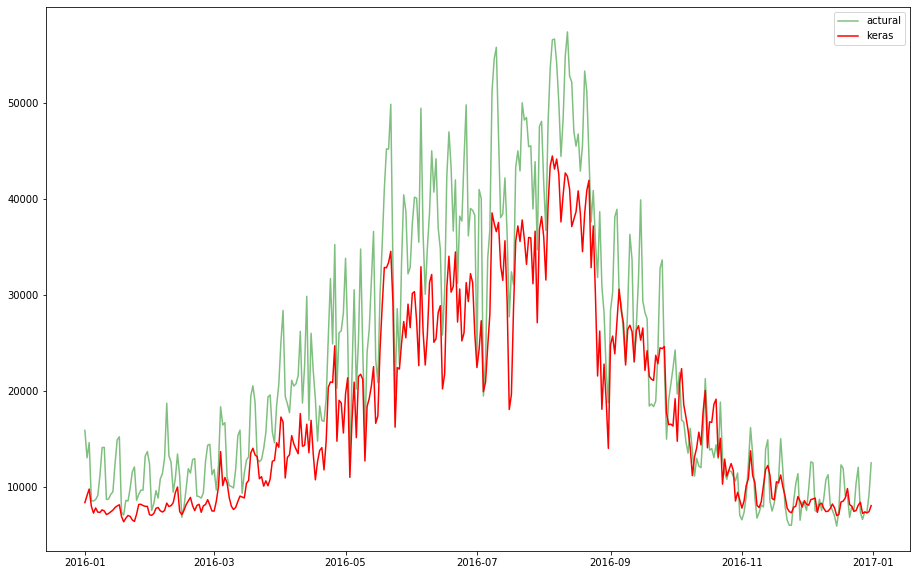

In [100]:
df_graph = result_df.loc[result_df.date.between('2016-01-01','2016-12-31')]
plt.figure(figsize=(15.5, 10))
plt.plot(df_graph.date,df_graph.qty, ls='-', label='actural', color='green', alpha=0.5)
plt.plot(df_graph.date,df_graph.keras_qty, ls='-', label='keras', color='r')
# plt.plot(df_graph.date,df_graph.rf_qty, ls='--', label='rf', color='cyan')
# plt.plot(df_graph.date,df_graph.xgb_qty, ls='--', label='xgb', color='green')
plt.legend()
plt.show()

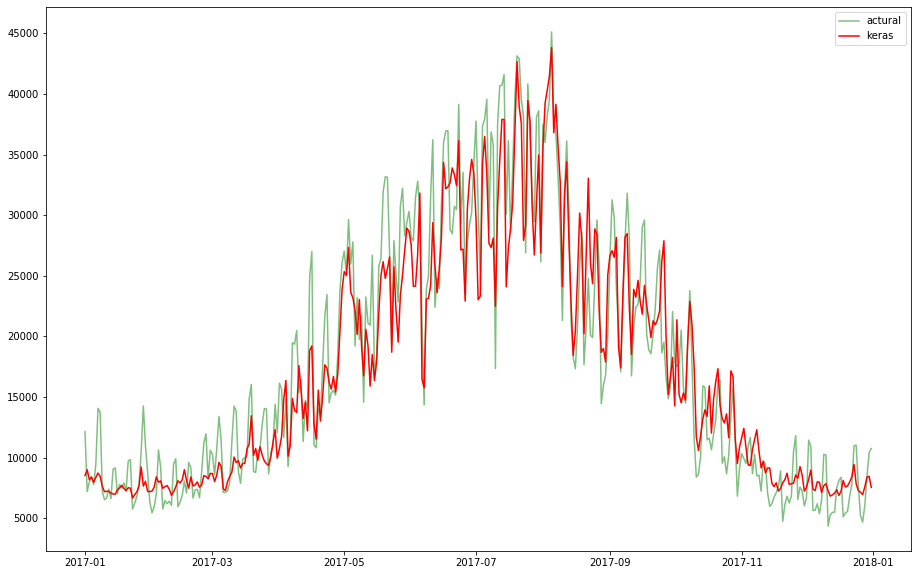

In [101]:
df_graph = result_df.loc[result_df.date.between('2017-01-01','2017-12-31')]
plt.figure(figsize=(15.5, 10))
plt.plot(df_graph.date,df_graph.qty, ls='-', label='actural', color='green', alpha=0.5)
plt.plot(df_graph.date,df_graph.keras_qty, ls='-', label='keras', color='r')
# plt.plot(df_graph.date,df_graph.rf_qty, ls='--', label='rf', color='cyan')
# plt.plot(df_graph.date,df_graph.xgb_qty, ls='--', label='xgb', color='green')
plt.legend()
plt.show()

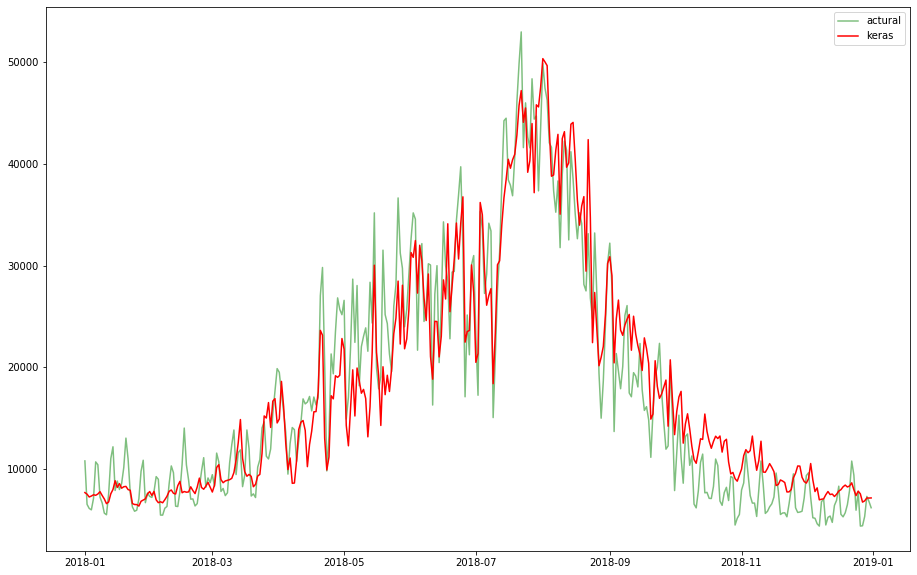

In [102]:
df_graph = result_df.loc[result_df.date.between('2018-01-01','2018-12-31')]
plt.figure(figsize=(15.5, 10))
plt.plot(df_graph.date,df_graph.qty, ls='-', label='actural', color='green', alpha=0.5)
plt.plot(df_graph.date,df_graph.keras_qty, ls='-', label='keras', color='r')
# plt.plot(df_graph.date,df_graph.rf_qty, ls='--', label='rf', color='cyan')
# plt.plot(df_graph.date,df_graph.xgb_qty, ls='--', label='xgb', color='green')
plt.legend()
plt.show()

In [63]:
path = 'D:/project/contest/data/result/'
result_df.to_csv(path+item+'_'+grouped_by+'_predict.csv', encoding='utf-8', index=False)

W0717 11:49:08.747567  6212 legend.py:1282] No handles with labels found to put in legend.


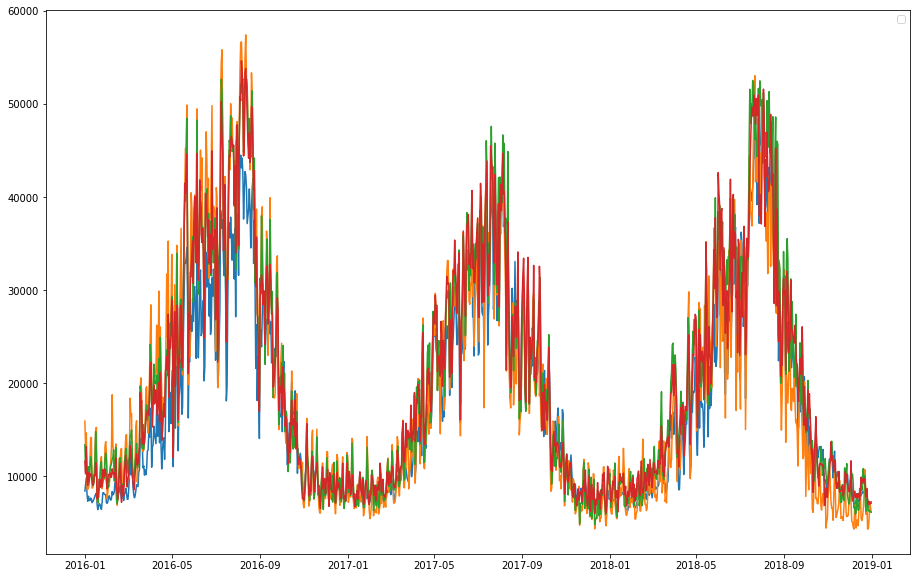

In [64]:
plt.figure(figsize=(15.5, 10))
plt.plot(result_df.date,result_df.keras_qty)
plt.plot(result_df.date,result_df.qty)
plt.plot(result_df.date,result_df.rf_qty)
plt.plot(result_df.date,result_df.xgb_qty)
plt.legend()
plt.show()

In [65]:
result_df.head(2)

,date,qty,keras_qty,rf_qty,xgb_qty
0,2016-01-01,15929,8426.595703,13399.5,11620.145508
1,2016-01-02,13086,9169.041016,10552.9,10274.932617


In [71]:
result_df['keras_accu'] = abs( (result_df.keras_qty / result_df.qty) )
result_df['rf_accu'] = abs( (result_df.rf_qty / result_df.qty) )
result_df['xgb_accu'] = abs( (result_df.xgb_qty / result_df.qty) )
result_df.tail()

,date,qty,keras_qty,rf_qty,xgb_qty,keras_accu,rf_accu,xgb_accu
1091,2018-12-27,4373,6703.843750,6340.2,6974.329590,1.533008,1.449851,1.594862
1092,2018-12-28,5291,6825.353516,6262.0,7324.298828,1.289993,1.183519,1.384294
1093,2018-12-29,7264,7114.427734,6340.2,7017.622559,0.979409,0.872825,0.966082
1094,2018-12-30,6758,7102.999023,6181.2,7134.472168,1.051050,0.914649,1.055708
1095,2018-12-31,6149,7114.062500,6159.8,7266.663574,1.156946,1.001756,1.181763


In [76]:
result_df['qtyMinusMean'] = (result_df.qty-np.mean(result_df.qty) )
result_df['qtyMinusMeanSquared'] = (result_df.qty-np.mean(result_df.qty) )**2

In [83]:
result_df['kerasMiunsMeanSquared'] = (result_df.keras_qty-np.mean(result_df.qty))**2
result_df['rfMiunsMeanSquared'] = (result_df.rf_qty-np.mean(result_df.qty))**2
result_df['xgbMiunsMeanSquared'] = (result_df.xgb_qty-np.mean(result_df.qty))**2

In [84]:
print('kreas R-sq',(sum(result_df['kerasMiunsMeanSquared']) / sum(result_df['qtyMinusMeanSquared'])))
print('rf R-sq',(sum(result_df['rfMiunsMeanSquared']) / sum(result_df['qtyMinusMeanSquared'])))
print('xgb R-sq',(sum(result_df['xgbMiunsMeanSquared']) / sum(result_df['qtyMinusMeanSquared'])))

kreas R-sq 0.7336826837250119
rf R-sq 1.029792289129592
xgb R-sq 0.9544366599340366
